In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog
from sklearn.svm import LinearSVC
from skimage.io import imread
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score


In [3]:
def num_images(image_path):
    count = 0
    for dir1 in os.listdir(image_path):
        count += len(os.listdir(os.path.join(image_path, dir1)))
    return count

In [4]:
# split data
split_ratio = math.floor(0.8 * num_images('train_images'))

data = pd.read_csv('./train.csv')
data = data[['video_id', 'video_frame', 'annotations']]
data["annotations"] = data["annotations"].map(lambda x: eval(x))

In [5]:
data['count'] = 0
for i in range(0, len(data['annotations'])):
    data['count'][i] = len(data['annotations'][i])
data

/var/folders/77/0t0g2h210_19tdxlx4g8f3yc0000gn/T/ipykernel_97230/3157417638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['count'][i] = len(data['annotations'][i])


,video_id,video_frame,annotations,count
0,0,0,[],0
1,0,1,[],0
2,0,2,[],0
3,0,3,[],0
4,0,4,[],0
...,...,...,...,...
23496,2,10755,[],0
23497,2,10756,[],0
23498,2,10757,[],0
23499,2,10758,[],0


In [7]:
training_df = data[0:split_ratio]
testing_df = data[split_ratio:]
training_df

,video_id,video_frame,annotations,count
0,0,0,[],0
1,0,1,[],0
2,0,2,[],0
3,0,3,[],0
4,0,4,[],0
...,...,...,...,...
18795,2,4727,"[{'x': 148, 'y': 521, 'width': 45, 'height': 48}]",1
18796,2,4728,"[{'x': 134, 'y': 518, 'width': 45, 'height': 48}]",1
18797,2,4729,"[{'x': 120, 'y': 515, 'width': 45, 'height': 48}]",1
18798,2,4730,"[{'x': 114, 'y': 511, 'width': 45, 'height': 48}]",1


In [8]:
# window_size = (64,128)
window_size = (720, 1280)

train_images = []
hog_images = []

cots_df = []
no_cots_df = []

cots_features = []
no_cots_features = []

cots_labels = []
no_cots_labels = []

# for i in range(0, len(training_df['video_id'])):
for i in range(0, 1000):
    video_id = str(training_df['video_id'][i])
    frame_id = str(training_df['video_frame'][i])
    path = 'train_images/video_'+video_id+'/'+frame_id+'.jpg'
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    train_images.append(img)
    
    if training_df['count'][i] == 0:
        # If no COTS in image
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, window_size)
        no_cots_df.append(img)
        feature = hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=False, feature_vector=True)
        no_cots_features.append(feature)
        no_cots_labels.append(0)
    else:
        # If COTS is in image
        for j in training_df['annotations'][i]:
            cots = img[j['y']:j['y']+j['height'], j['x']:j['x']+j['width']]
            cots = cv2.cvtColor(cots, cv2.COLOR_RGB2GRAY)
            cots = cv2.resize(cots, window_size)
            cots_df.append(cots)
            feature, hog_image = hog(cots, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True, feature_vector=True)
            cots_features.append(feature)
            hog_images.append(hog_image)
            cots_labels.append(training_df['count'][i])


(1030, 509437)


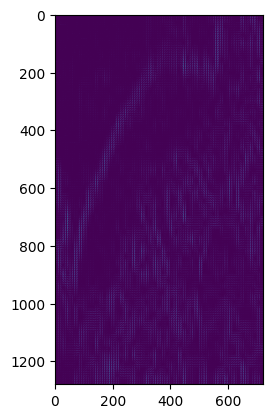

In [9]:
plt.imshow(hog_images[0])

x = np.asarray(cots_features + no_cots_features)
y = np.asarray(cots_labels + no_cots_labels)
y =  np.array(y).reshape(len(y),1)
data_frame = np.hstack((x,y))
print(data_frame.shape)
np.random.shuffle(data_frame)

percentage = 80
partition = int(len(x)*percentage/100)

x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

In [11]:
model = LinearSVC()
model.fit(x_train, y_train)
# Get predicitions on test data using model
y_pred = model.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("F1 Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
print("F2 Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))

Accuracy:  0.9854368932038835
Precision:  0.9396825396825398
Recall:  0.9603072983354674
F1 Score:  0.9494295405488745
F2 Score:  0.9558111380145279


In [12]:
def get_image_paths(image_folder):
    image_paths = []
    for dir1 in os.listdir(image_folder):
        image_path = os.path.join(image_folder, dir1)
        image_paths.append(image_path)
            
    return image_paths

test_images = get_image_paths('test_images')

test_y_preds = []
test_y_tests = [[0], [0], [1], [2], [0], [0], [0], [0], [0], [0]]
# Get predicitions on test_data images using model
i = 0
for image in test_images:
    img = cv2.imread(image, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, window_size)
    feature = hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=False, feature_vector=True)
    test_y_pred = model.predict(feature.reshape(1,-1))
    test_y_preds.append(test_y_pred)
    i += 1

print("Accuracy: ", accuracy_score(test_y_tests, test_y_preds))
print("Precision: ", precision_score(test_y_tests, test_y_preds, average='macro'))
print("Recall: ", recall_score(test_y_tests, test_y_preds, average='macro'))
print("F1 Score: ", fbeta_score(test_y_tests, test_y_preds, beta=1, average='macro'))
print("F2 Score: ", fbeta_score(test_y_tests, test_y_preds, beta=2, average='macro'))


Accuracy:  0.8
Precision:  0.26666666666666666
Recall:  0.3333333333333333
F1 Score:  0.29629629629629634
F2 Score:  0.31746031746031744


/Users/joeljose/opt/anaconda3/envs/cotsenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
